The goal of this project is to develop a machine learning algorithm to classify retinal OCT images into four classes: Normal (healthy), CNV (Choroidal Neo-Vascularization), DME (diabetic macular edema), and Drusen (a buildup of lipids in the retina associated with Macular Degneration). This type of model is important for the early detection and diagnosis of these retinal diseases, as treatment options for these diseases are much more successful when they are caught in early stages. This project will explore OCT, a non-invasive imaging modality, as a means for detecting these conditions by building an ML classifier for retinal OCT images. 

The first step is to install/import all necessary python libraries

In [1]:
!pip install keract

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

The data for this project is available at: https://data.mendeley.com/datasets/rscbjbr9sj/2

This data was downloaded and saved in a 'Data' folder in the same directory as this notebook. The data is separated into training and testing folders, with each of these folders containing 4 subfolders ('Normal','CNV','DME', and 'Drusen'). These images will be re-sized to 150x150 prior to model training, since the dimensions of the raw images are not consistent.

In [48]:
base_folder = os.path.dirname(os.getcwd())
data_dir = base_folder+'/Data/OCT2017/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

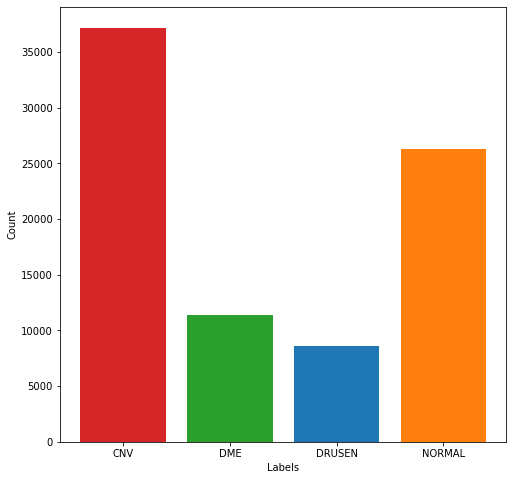

In [49]:
#Plot a frequency distribution showing the number of images per class in the training dataset

cnv_images = len(glob(train_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

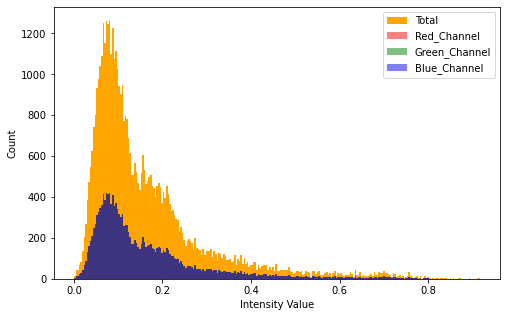

In [51]:
#Plot the tonal distribution of a healthy retina image

image = mpimg.imread(data_dir + 'train/NORMAL/NORMAL-1384-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

The following cells are used to visualize a couple sample OCT images from each class. 

Normal


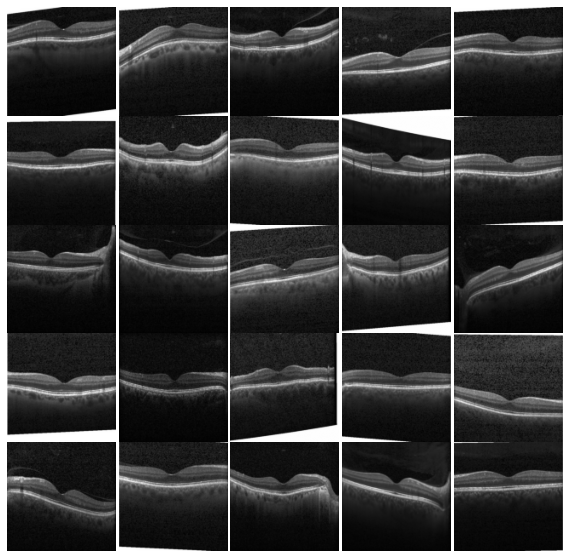

In [30]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


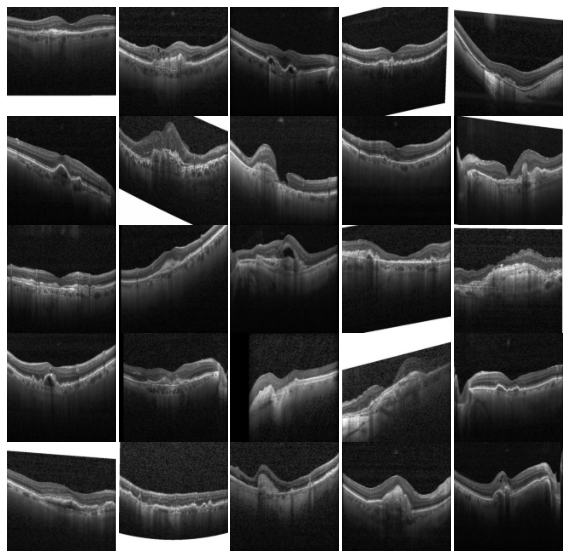

In [31]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


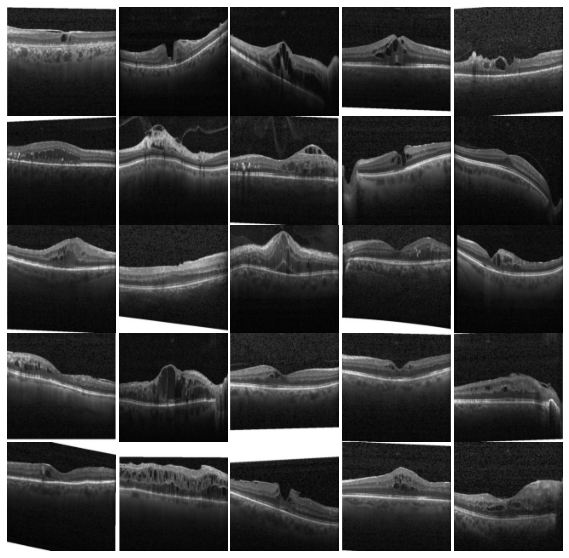

In [32]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


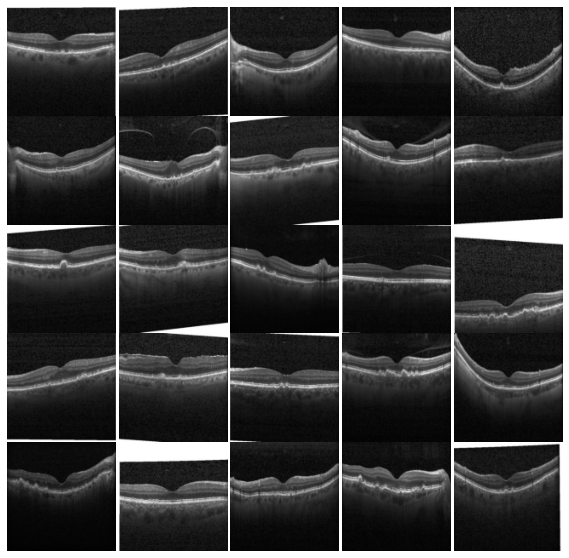

In [52]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

In [53]:
train_ds = keras.preprocessing.image_dataset_from_directory(train_dir,batch_size=batch_size,
                                                            image_size=(img_width,img_height),
                                                            validation_split=0.1,subset='training',seed=1337,
                                                           label_mode='categorical')
val_ds = keras.preprocessing.image_dataset_from_directory(train_dir,batch_size=batch_size,
                                                            image_size=(img_width,img_height),
                                                            validation_split=0.1,subset='validation',seed=1337,
                                                         label_mode='categorical')
test_ds = keras.preprocessing.image_dataset_from_directory(test_dir,batch_size=batch_size,
                                                            image_size=(img_width,img_height),
                                                           label_mode='categorical')

Found 83484 files belonging to 4 classes.
Using 75136 files for training.
Found 83484 files belonging to 4 classes.
Using 8348 files for validation.
Found 1000 files belonging to 4 classes.


In [54]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [55]:
#Fully frozen model
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [56]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [57]:
num_epochs = 30

history = model.fit(
    train_ds, 
    epochs = num_epochs,
    validation_data = val_ds, 
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
2348/2348 - 18083s - loss: 1.9231 - accuracy: 0.7577 - val_loss: 0.8072 - val_accuracy: 0.8492

Epoch 00001: val_loss improved from inf to 0.80716, saving model to baseline_model.h5
Epoch 2/30
2348/2348 - 4506s - loss: 0.9280 - accuracy: 0.8319 - val_loss: 0.6165 - val_accuracy: 0.8640

Epoch 00002: val_loss improved from 0.80716 to 0.61650, saving model to baseline_model.h5
Epoch 3/30
2348/2348 - 3753s - loss: 0.6731 - accuracy: 0.8531 - val_loss: 0.5203 - val_accuracy: 0.8758

Epoch 00003: val_loss improved from 0.61650 to 0.52031, saving model to baseline_model.h5
Epoch 4/30
2348/2348 - 7596s - loss: 0.5564 - accuracy: 0.8637 - val_loss: 0.4937 - val_accuracy: 0.8739

Epoch 00004: val_loss improved from 0.52031 to 0.49372, saving model to baseline_model.h5
Epoch 5/30
2348/2348 - 7120s - loss: 0.4913 - accuracy: 0.8712 - val_loss: 0.4611 - val_accuracy: 0.8723

Epoch 00005: val_loss improved from 0.49372 to 0.46109, saving model to baseline_model.h5
Epoch 6/30
2348/2348 - 

In [58]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

32/32 [==============================] - 43s 1s/step - loss: 0.1394 - accuracy: 0.9540
Test Loss:  0.13939213752746582
Test Accuracy:  0.9539999961853027


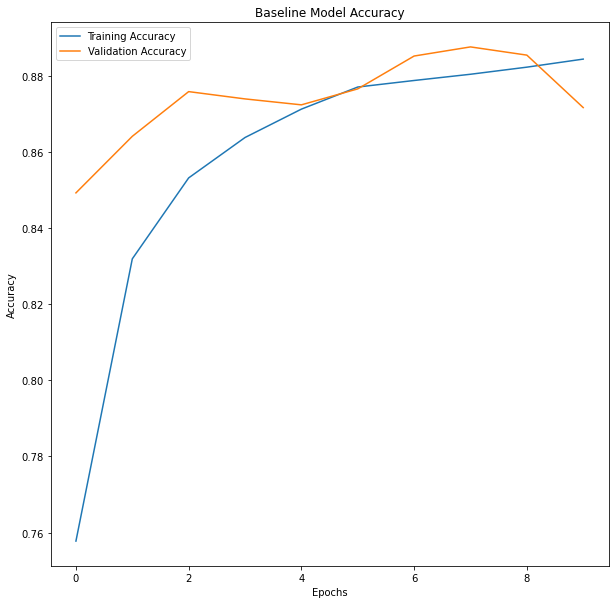

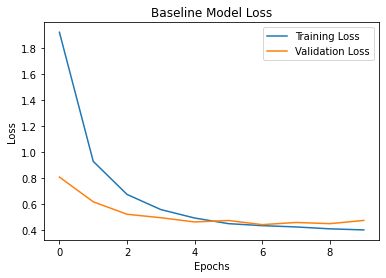

In [59]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [71]:
#Loop through test dataset to collect labels/predictions in np array

predictions = np.array([])
labels = np.array([])
for img,lbl in test_ds:
    varPredictions = np.argmax(model.predict(img), axis=-1)
    varLabels = np.argmax(lbl, axis=-1)
    predictions = np.concatenate([predictions,varPredictions])
    labels = np.concatenate([labels,varLabels])



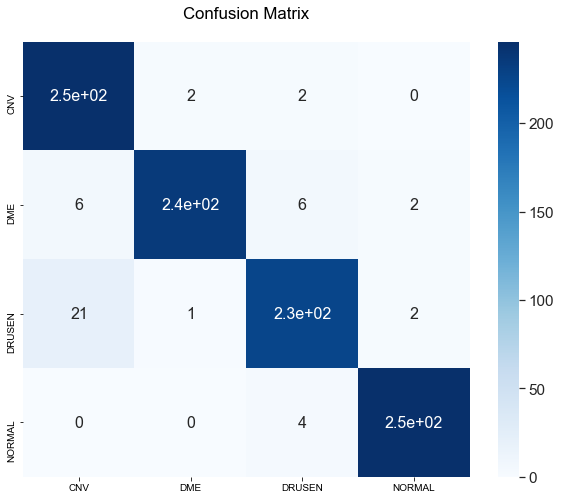

Classification Report

              precision    recall  f1-score   support

         CNV       0.90      0.98      0.94       250
         DME       0.99      0.94      0.97       250
      DRUSEN       0.95      0.90      0.93       250
      NORMAL       0.98      0.98      0.98       250

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [72]:
#Plot confusion matrix
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cm, list(data.keys()), list(data.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(data.keys())
print(classification_report(labels, predictions, target_names=target_names))

The next step is to fine-tune the model by unfreezing the imported VGG16 layers and decreasing the learning rate.

In [73]:
model.trainable= True
model.compile(optimizer= keras.optimizers.Adam(1e-5), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [74]:
checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "finetuned_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [75]:
num_epochs = 10

history_1 = model.fit(
    train_ds, 
    epochs = num_epochs,
    validation_data = val_ds, 
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10
2348/2348 - 11927s - loss: 0.2312 - accuracy: 0.9232 - val_loss: 0.1645 - val_accuracy: 0.9427

Epoch 00001: loss improved from inf to 0.23121, saving model to finetuned_model.h5
Epoch 2/10
2348/2348 - 15887s - loss: 0.1333 - accuracy: 0.9551 - val_loss: 0.1377 - val_accuracy: 0.9529

Epoch 00002: loss improved from 0.23121 to 0.13330, saving model to finetuned_model.h5
Epoch 3/10
2348/2348 - 13529s - loss: 0.0975 - accuracy: 0.9666 - val_loss: 0.1323 - val_accuracy: 0.9583

Epoch 00003: loss improved from 0.13330 to 0.09749, saving model to finetuned_model.h5
Epoch 4/10
2348/2348 - 47389s - loss: 0.0740 - accuracy: 0.9742 - val_loss: 0.1409 - val_accuracy: 0.9582

Epoch 00004: loss improved from 0.09749 to 0.07404, saving model to finetuned_model.h5
Epoch 5/10
2348/2348 - 12686s - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.1311 - val_accuracy: 0.9644

Epoch 00005: loss improved from 0.07404 to 0.05739, saving model to finetuned_model.h5
Epoch 6/10
2348/2348 - 11876s - lo

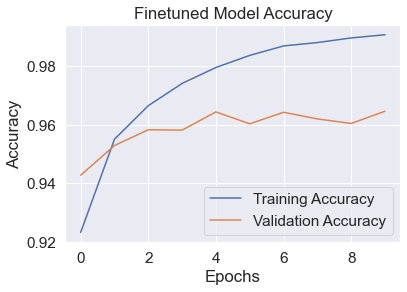

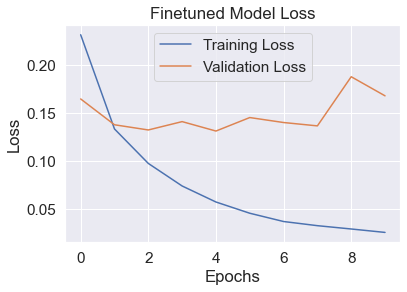

In [76]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [78]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

32/32 [==============================] - 45s 1s/step - loss: 0.0313 - accuracy: 0.9920
Test Loss:  0.03126819431781769
Test Accuracy:  0.9919999837875366


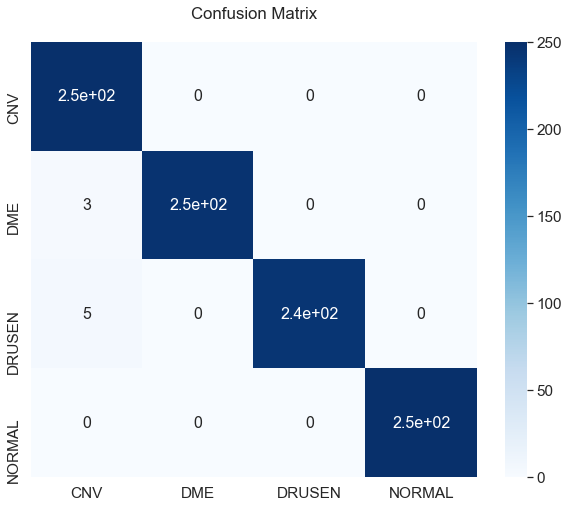

Classification Report

              precision    recall  f1-score   support

         CNV       0.97      1.00      0.98       250
         DME       1.00      0.99      0.99       250
      DRUSEN       1.00      0.98      0.99       250
      NORMAL       1.00      1.00      1.00       250

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [79]:
#Loop through test dataset to collect labels/predictions in np array

predictions = np.array([])
labels = np.array([])
for img,lbl in test_ds:
    varPredictions = np.argmax(model.predict(img), axis=-1)
    varLabels = np.argmax(lbl, axis=-1)
    predictions = np.concatenate([predictions,varPredictions])
    labels = np.concatenate([labels,varLabels])
    
#Plot confusion matrix
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cm, list(data.keys()), list(data.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(data.keys())
print(classification_report(labels, predictions, target_names=target_names))